# Data analysis for introduction and Chapter "General Ensemble Properties"

This notebook can be used to reproduce the data analysis of the introduction and Chapter "General Ensemble Properties" of the technical report ["Assessing a Formal Model of Reflective Equilibrium"](https://re-models.github.io/re-technical-report/). 

## How to run this notebook

There are several possibilities to execute this notebook. You can, for instance,

1. execute this notebook on Colab: [![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/re-models/re-technical-report/blob/main/notebooks/chapter_general-props.ipynb), or
2. execute this notebook locally in, for instance, [JupyterLab](https://jupyter.org/) by cloning the Github repository of the report (for details, see <https://github.com/re-models/re-technical-report>).

Note, however, that Colab is not suited to analyse the full data set that is used in the report. Instead, you can only use the subdata set `TINY` (see <https://github.com/re-models/re-technical-report> for details).

## Installing and importing libraries

In [12]:
# !pip install --force-reinstall -v "re-technical-report==0.0.3a1"
# installing libraries
#!pip uninstall re-technical-report 
!pip install re-technical-report

In [71]:
# importing libraries
from pandas import Series, DataFrame
import pandas as pd
import numpy as np
from os import getcwd, path
from pathlib import Path
from statistics import mean
from ast import literal_eval

import matplotlib.pyplot as plt
import seaborn as sns

from re_technical_report import (
    re_data_by_name, 
    plot_multiple_error_bars,
    mean_simple_hamming_adjacents,
    heat_maps_by_weights,
    mean_simple_hamming_distance,
    mean_d_init_coms_go,
    set_errorbar_plot_style,
    set_heatmap_plot_style,
)


In [73]:
# Directories that are use to save generated tables and figures.
tables_output_dir = path.join(Path(getcwd()).parent.absolute(), "report", "tables")
figures_output_dir = path.join(Path(getcwd()).parent.absolute(), "report", "figures")
# Are we on Colab?
on_colab = 'google.colab' in str(get_ipython())
# Configuring sns styles
set_errorbar_plot_style()
set_heatmap_plot_style()

## Loading data

In [25]:
# Columns relevant for this notebook.
usecols = ['model_name', 'ds', 'init_coms', 'n_sentence_pool', 'error_code' , 'process_length', 
           'weight_account', 'weight_systematicity', 'weight_faithfulness',
           'ds_infer_dens', 'init_coms_size', 'init_coms_dia_consistent', 'n_global_optima',
           'init_final_coms_simple_hamming', 'n_fixed_points',
            'coms_evolution',#'theory_evolution',
           'global_optima']

In [26]:
# data_name: one of 'TINY', 'MINI', 'FULL'
re_data = re_data_by_name(data_name="TINY", 
                          usecols=usecols,
                          filter_erroneous_runs=False)

In [7]:
print(f"The data set contains {sum(re_data['error_code'].isna()==False)}/{len(re_data)} rows of erroneous model runs.")
# filter
re_data = re_data.loc[re_data['error_code'].isna()]

The data set contains 0/12637 rows of erroneous model runs.


In [8]:
print('\033[1m' + 'General information: ' + '\033[0m')
print("   Amount of rows:" , len(re_data))
print('   Number of dialectical structures:', len(re_data['ds'].unique()))
print('   Overall number of initial commitments:', len(re_data['init_coms'].unique()))
print('   Sentence-pools:' , re_data['n_sentence_pool'].unique())
print('   Models:' , re_data['model_name'].unique())

General information: 
   Amount of rows: 12637
   Number of dialectical structures: 2
   Overall number of initial commitments: 40
   Sentence-pools: [6 7]
   Models: ['QuadraticGlobalRE' 'LinearGlobalRE' 'QuadraticLocalRE' 'LinearLocalRE']


In [9]:
# counting simulation setups
re_data_unique_setups = re_data.drop_duplicates(["model_name",
                         "ds",
                         "n_sentence_pool",
                         'weight_account', 
                         'weight_systematicity',
                         'weight_faithfulness', 
                         'init_coms'
                        ])
re_data_unique_setups.groupby(['model_name']).size()

model_name
LinearGlobalRE       1440
LinearLocalRE        1440
QuadraticGlobalRE    1440
QuadraticLocalRE     1440
dtype: int64

In [39]:
# For the global optima we want to compare linear and quadratic variants. For a proper labeling we include another columns.
# df["group"] = df["group"].map({0: "zero", 1; "one"})
re_data['q_or_l_model'] = re_data['model_name'].map({'QuadraticGlobalRE':'QuadraticRE', 
                                                     'LinearGlobalRE':'LinearRE', 
                                                     'QuadraticLocalRE':'QuadraticRE', 
                                                     'LinearLocalRE':'LinearRE'})

## Dialectical structures

### Distribution: inferential density

In [11]:
re_data.drop_duplicates(["ds"])["ds_infer_dens"].describe()

count    2.000000
mean     0.394713
std      0.086804
min      0.333333
25%      0.364023
50%      0.394713
75%      0.425402
max      0.456092
Name: ds_infer_dens, dtype: float64

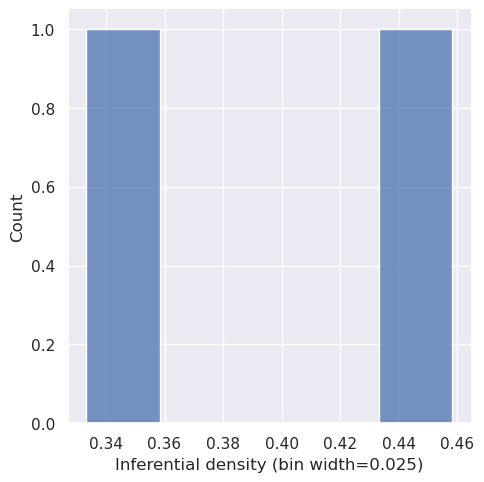

In [74]:
#re_data.drop_duplicates(["ds", "ds_infer_dens"])
g = sns.displot(re_data.drop_duplicates(["ds"]), x="ds_infer_dens", binwidth=0.025)#, discrete=True) 
g.set_axis_labels(x_var='Inferential density (bin width=0.025)')
if not on_colab:
    g.savefig(path.join(figures_output_dir, 'distr-inf-dens.pdf'), bbox_inches='tight')
    g.savefig(path.join(figures_output_dir, 'distr-inf-dens.png'), bbox_inches='tight')

### Distribution: mean number of premises

count    2.000000
mean     1.125000
std      0.176777
min      1.000000
25%      1.062500
50%      1.125000
75%      1.187500
max      1.250000
Name: ds, dtype: float64

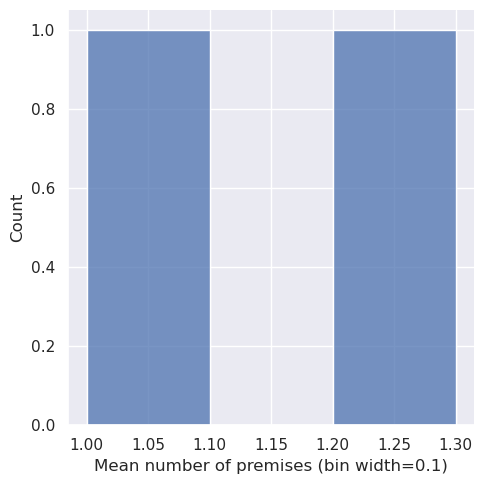

In [15]:
# WARNING: do not use `literal_eval` on unsave/unknown data
ser_ds = re_data.drop_duplicates(["ds"])["ds"]
ser_ds = ser_ds.apply(lambda x: literal_eval(x))
ser_ds = ser_ds.apply(lambda tau: mean([len(arg)-1 for arg in tau]))
display(ser_ds.describe())
#display(ser_ds)
g = sns.displot(ser_ds, binwidth=0.1)
g.set_axis_labels(x_var='Mean number of premises (bin width=0.1)')
if not on_colab:
    g.savefig(path.join(figures_output_dir, 'mean-number-premises.pdf'), bbox_inches='tight')
    g.savefig(path.join(figures_output_dir, 'mean-number-premises.png'), bbox_inches='tight')

## Initial commitments

### Consistency

In [16]:
# mean number of dialectically consistent positions
print(sum(re_data.drop_duplicates(["init_coms","ds"])["init_coms_dia_consistent"])/len(re_data.drop_duplicates(["init_coms","ds"])["init_coms_dia_consistent"]))
#re_data.drop_duplicates(["init_coms","ds"])["init_coms_dia_consistent"].describe()

0.55


/tmp/ipykernel_3354413/482977536.py:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  rel_consistent_coms = re_data.drop_duplicates(["init_coms","ds","n_sentence_pool"])[["init_coms","ds","n_sentence_pool","init_coms_dia_consistent"]].groupby("n_sentence_pool").mean()


,init_coms_dia_consistent
n_sentence_pool,
6,0.7
7,0.4


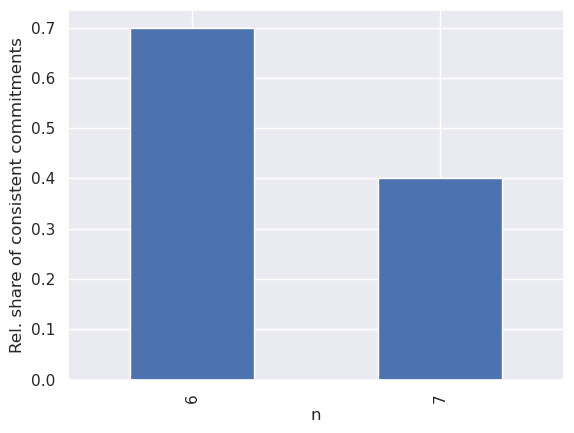

In [17]:
# mean number for different sentence pools
rel_consistent_coms = re_data.drop_duplicates(["init_coms","ds","n_sentence_pool"])[["init_coms","ds","n_sentence_pool","init_coms_dia_consistent"]].groupby("n_sentence_pool").mean()
display(rel_consistent_coms)
ax = rel_consistent_coms.plot(kind="bar")
plt.xlabel ('n')
plt.ylabel ('Rel. share of consistent commitments')
ax.get_legend().remove()

if on_colab:
    plt.savefig(path.join(figures_output_dir, 'consistency-init-coms.pdf'), bbox_inches='tight')
    plt.savefig(path.join(figures_output_dir, 'consistency-init-coms.png'), bbox_inches='tight')

### Size of initial commitments

In [18]:
re_data.drop_duplicates(["init_coms"])['init_coms_size'].describe()

count    40.000000
mean      4.100000
std       1.057331
min       2.000000
25%       3.750000
50%       4.000000
75%       5.000000
max       7.000000
Name: init_coms_size, dtype: float64

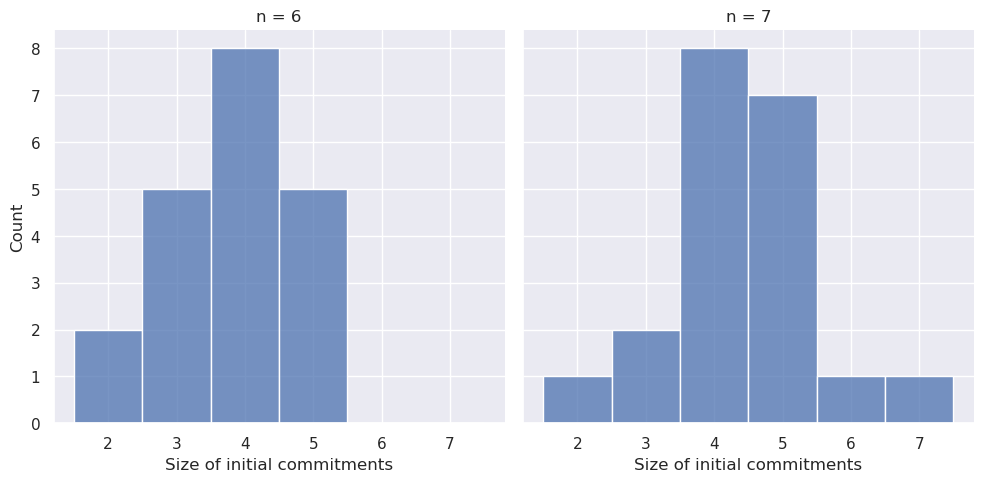

In [19]:
g = sns.displot(re_data.drop_duplicates(['init_coms', 'n_sentence_pool']), x='init_coms_size', 
            col='n_sentence_pool', col_wrap=2, discrete=True) 
g.set_axis_labels(x_var='Size of initial commitments')
#g.set_titles(row_template=f'{col_var}')
g.set_titles("n = {col_name}")
if on_colab:
    g.savefig(path.join(figures_output_dir, 'size-init-coms.pdf'), bbox_inches='tight')
    g.savefig(path.join(figures_output_dir, 'size-init-coms.png'), bbox_inches='tight')

## Process length

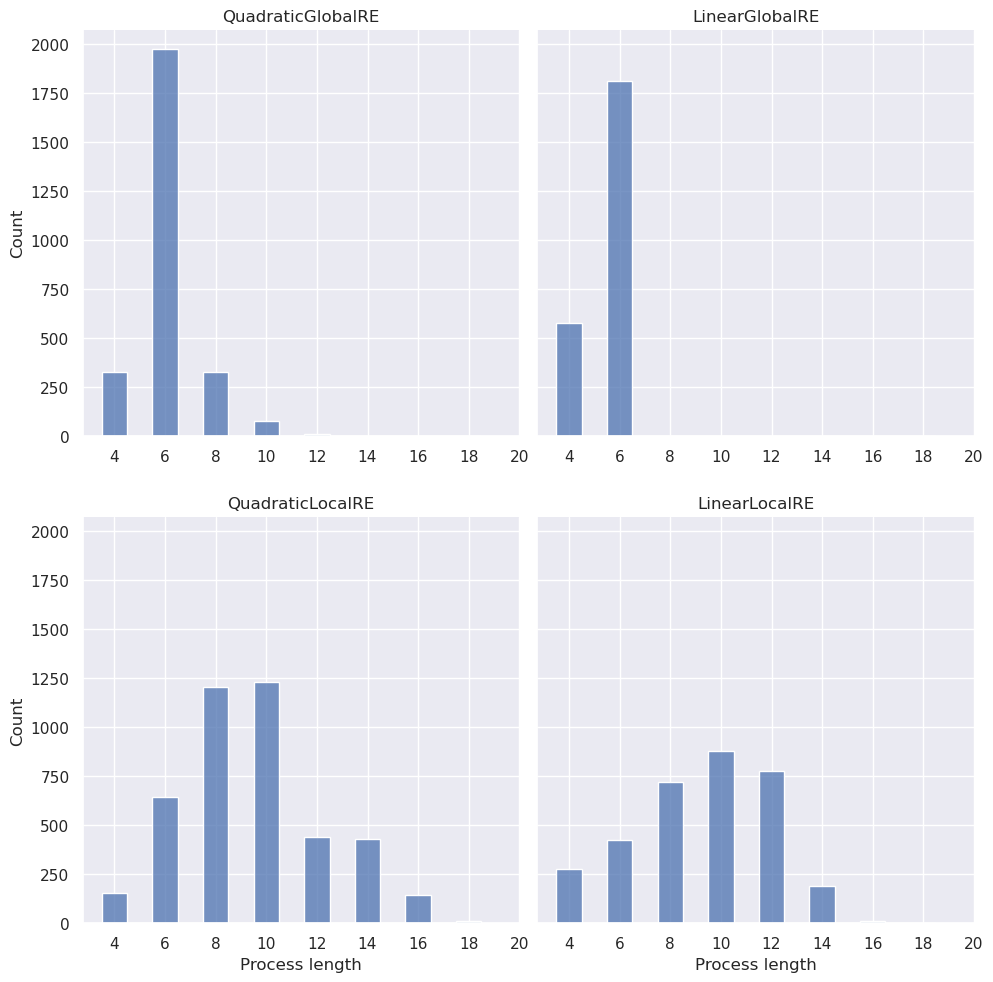

In [75]:
g = sns.displot(re_data, x='process_length', col='model_name', 
                col_wrap=2, discrete=True) 
g.set_axis_labels(x_var='Process length')
g.set_titles("{col_name}")
plt.xticks([i*2 for i in range(2,11)])
for ax in g.axes.flatten():
    ax.tick_params(labelbottom=True)
plt.subplots_adjust(hspace=0.2)
if on_colab:
    g.savefig(path.join(figures_output_dir, 'dist-process-length.pdf'), bbox_inches='tight')
    g.savefig(path.join(figures_output_dir, 'dist-process-length.png'), bbox_inches='tight')

Here, we consider all branches.

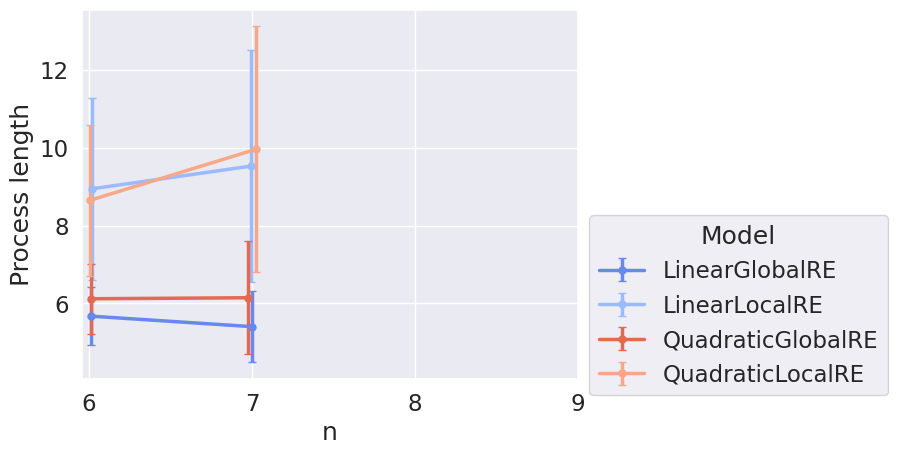

In [76]:
plot_multiple_error_bars(data=re_data, 
                         var_y='process_length', 
                         ylabel='Process length',
                         file_name=None if on_colab else 'process-length', 
                         output_dir=figures_output_dir)

## Step length

In [31]:
# for each branch: the mean distance between adjacent commitments in the evolution of commitments
re_data['mean_step_size_coms'] = re_data.apply(lambda x: mean_simple_hamming_adjacents(list(x['coms_evolution'])[:-1]), axis = 1)

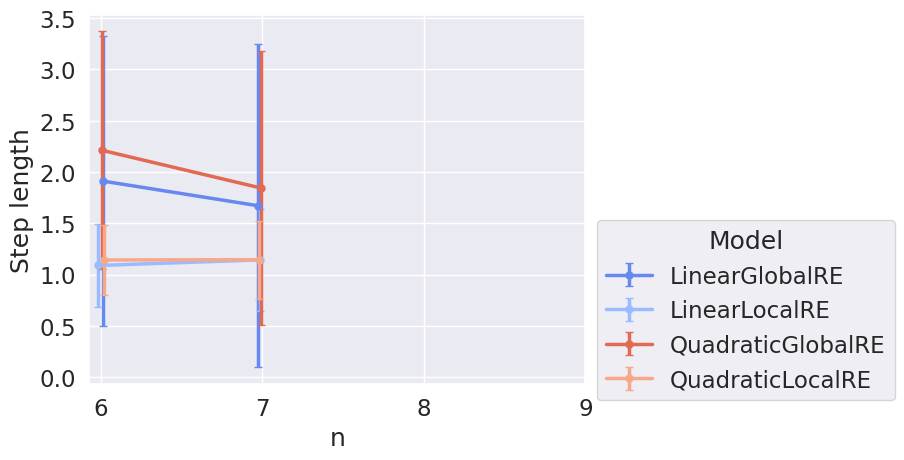

In [32]:
plot_multiple_error_bars(data=re_data, 
                         var_y='mean_step_size_coms', 
                         ylabel='Step length',
                         file_name='step-length', output_dir=figures_output_dir)

## Distance init coms to fixed points coms

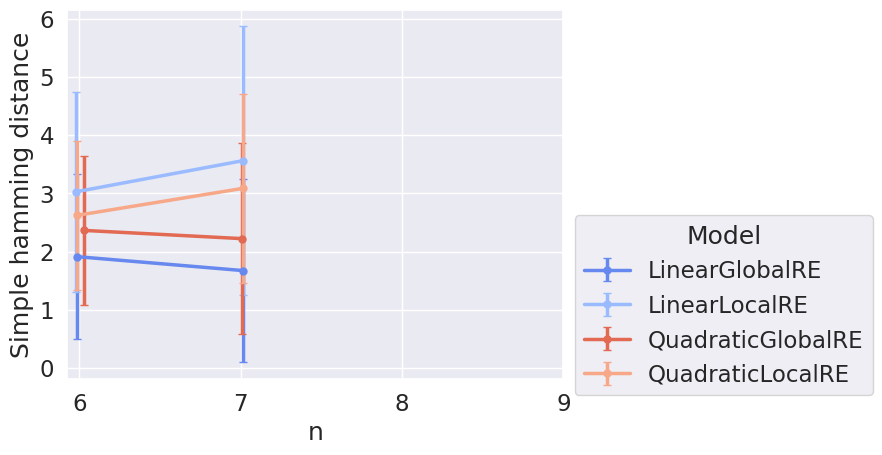

In [33]:
# init_final_coms_simple_hamming
plot_multiple_error_bars(data=re_data, 
                         var_y='init_final_coms_simple_hamming', 
                         ylabel='Simple hamming distance',
                         file_name=None if on_colab else 'distance-init-final-coms', 
                         output_dir=figures_output_dir)

## Global optima

### Number of global optima

In [41]:
cols_group_branches = ['model_name','ds','init_coms', 'weight_account', 'weight_systematicity'] 
data_collapsed = re_data.drop_duplicates(cols_group_branches)

In [42]:
data_collapsed.groupby('model_name')['n_global_optima'].describe()

,count,mean,std,min,25%,50%,75%,max
model_name,,,,,,,,
LinearGlobalRE,1440.0,2.804167,4.851569,1.0,1.0,2.0,3.0,90.0
LinearLocalRE,1440.0,2.804167,4.851569,1.0,1.0,2.0,3.0,90.0
QuadraticGlobalRE,1440.0,2.916667,3.712945,1.0,1.0,2.0,3.0,42.0
QuadraticLocalRE,1440.0,2.916667,3.712945,1.0,1.0,2.0,3.0,42.0


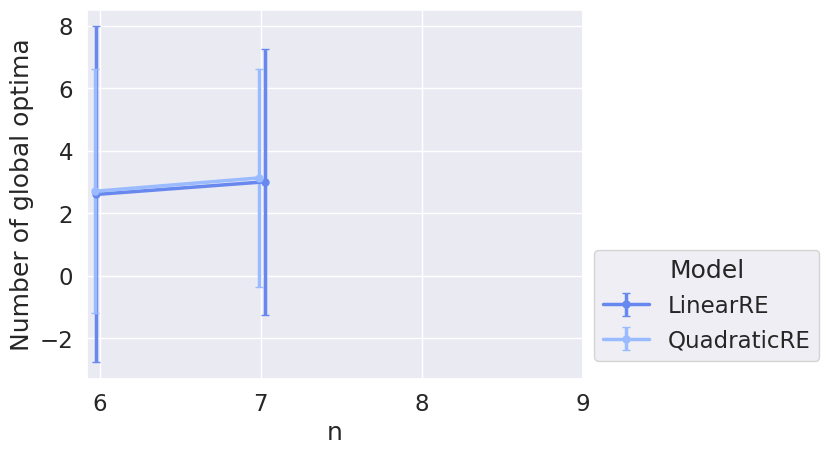

In [43]:
# n_global_optima (by model)
plot_multiple_error_bars(data=data_collapsed.loc[(data_collapsed['model_name']=='QuadraticGlobalRE') | (data_collapsed['model_name']=='LinearGlobalRE')], 
                         var_y='n_global_optima', 
                         ylabel='Number of global optima',
                         alt_labels={'QuadraticGlobalRE':'QuadraticRE', 'LinearGlobalRE':'LinearRE'},
                         file_name=None if on_colab else 'number-global-optima', 
                         output_dir=figures_output_dir)


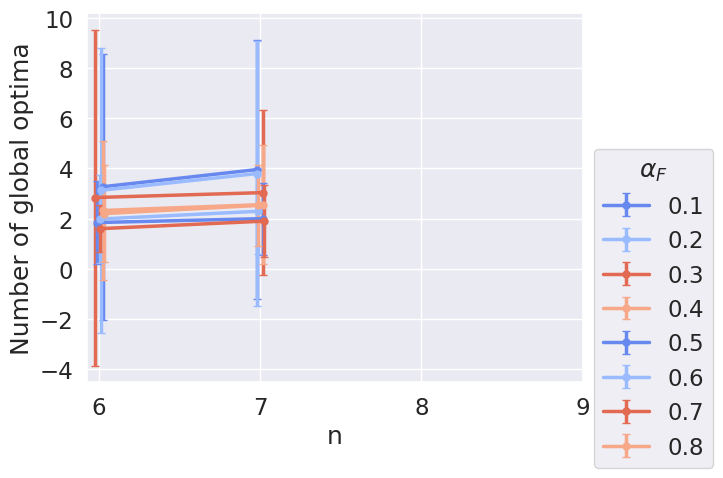

In [44]:
# n_global_optima (by alpha_f)
plot_multiple_error_bars(data=data_collapsed, 
                         var_y='n_global_optima', 
                         ylabel='Number of global optima',
                         var_hue='weight_faithfulness', 
                         hue_title=r'$\alpha_F$', 
                         file_name=None if on_colab else 'number_global_optima', 
                         output_dir=figures_output_dir)


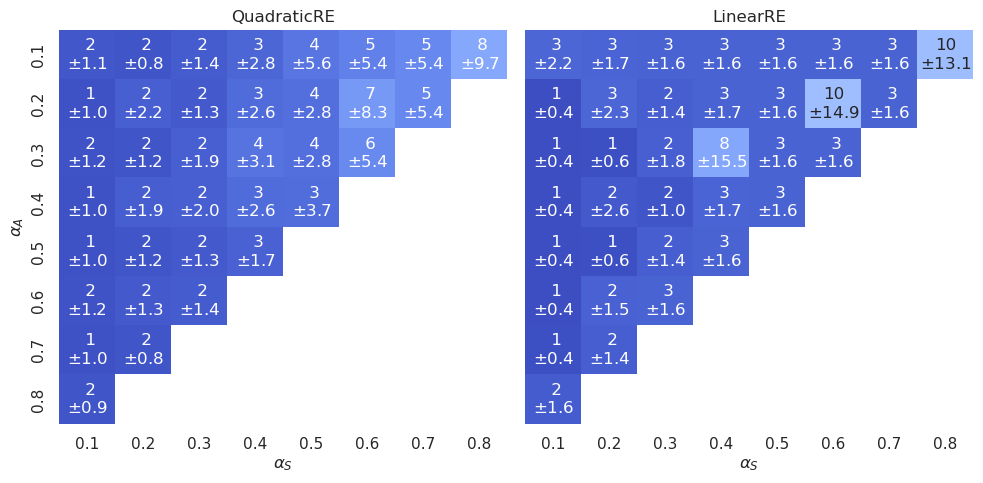

In [45]:
heat_maps_by_weights(re_data = data_collapsed.loc[(data_collapsed['model_name']=='QuadraticGlobalRE') | (data_collapsed['model_name']=='LinearGlobalRE')], 
                     values = 'n_global_optima', 
                     #title = 'Mean number of global optima', 
                     annot_std = True, annot_std_fmt = r'$\pm${:2.1f}', vmin=1, vmax=32,
                     col_model='q_or_l_model',
                     file_name=None if on_colab else 'hm-mean-n-global-optima', 
                     output_dir=figures_output_dir)

### Mean distance of global optima

We calculate the mean (simple Hamming) distance of global optima for those simulation setups that 
have more than one global optimum. Accordingly, it is important to know the extent of non-unique global optima
in simulation setup to interpret the results.

In [48]:
# calculating the mean distance (rows with only one go will receive NaN/None as value)
re_data['distance_go'] = re_data.apply(lambda x: mean_simple_hamming_distance([go_coms for go_theory, go_coms in x['global_optima']]), axis=1) 
# one row per simulation setup
cols_group_branches = ['model_name','ds','init_coms', 'weight_account', 'weight_systematicity'] 
data_collapsed = re_data.drop_duplicates(cols_group_branches)

In [49]:
# share of simulation setups that have more than one global optimum 
sum(data_collapsed['distance_go'].notna())/len(data_collapsed)

0.5597222222222222

In [50]:
# share of simulation setups that have more than one global optimum (for each model) 
data_collapsed.groupby('model_name').agg({'distance_go': lambda x: sum(x.notna())/len(x)})

,distance_go
model_name,
LinearGlobalRE,0.553472
LinearLocalRE,0.553472
QuadraticGlobalRE,0.565972
QuadraticLocalRE,0.565972


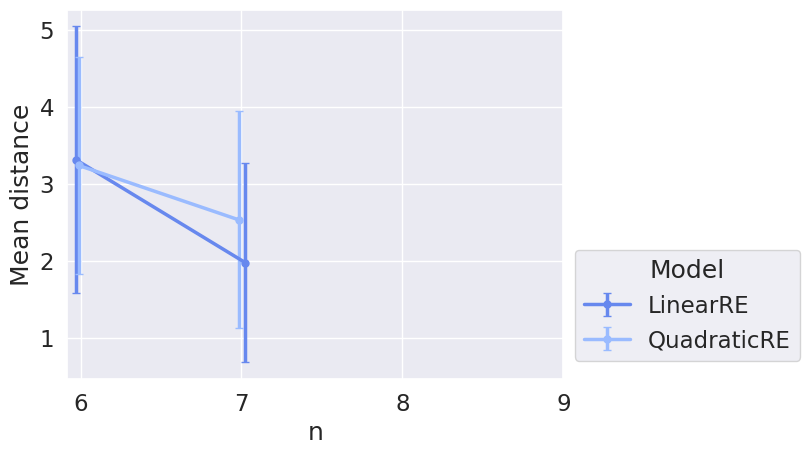

In [51]:
# by model
plot_multiple_error_bars(data=data_collapsed.loc[(data_collapsed['model_name']=='QuadraticGlobalRE') | (data_collapsed['model_name']=='LinearGlobalRE')], 
                         var_y='distance_go', 
                         ylabel='Mean distance',
                         alt_labels={'QuadraticGlobalRE':'QuadraticRE', 'LinearGlobalRE':'LinearRE'},
                         file_name=None if on_colab else 'mean-distance-global-optima-n', 
                         output_dir=figures_output_dir)


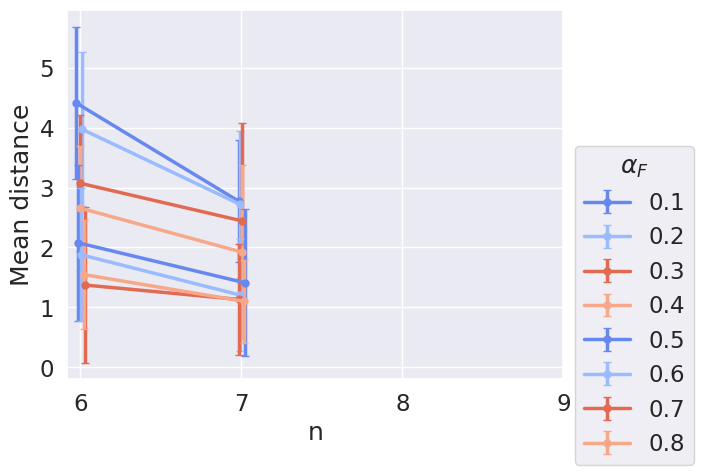

In [52]:
# by alpha_f
plot_multiple_error_bars(data=data_collapsed, 
                         var_y='distance_go', 
                         ylabel='Mean distance',
                         var_hue='weight_faithfulness', 
                         hue_title=r'$\alpha_F$', 
                         file_name=None if on_colab else 'mean-distance-global-optima-al', 
                         output_dir=figures_output_dir)                         

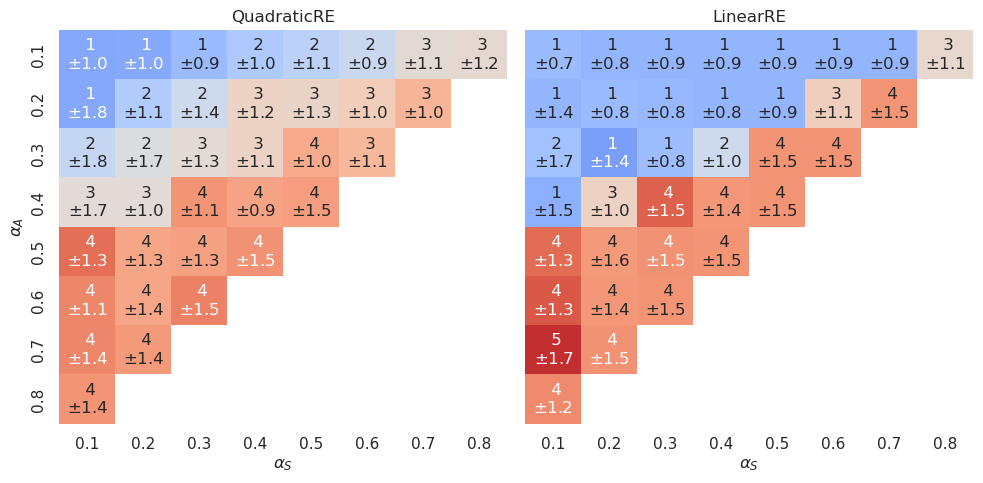

In [53]:
heat_maps_by_weights(re_data = data_collapsed.loc[(data_collapsed['model_name']=='QuadraticGlobalRE') | (data_collapsed['model_name']=='LinearGlobalRE')], 
                     values = 'distance_go', 
                     #title = 'Mean distance', 
                     col_model='q_or_l_model',
                     annot_std = True, annot_std_fmt = r'$\pm${:2.1f}', 
                     vmin=0, vmax=5,
                     file_name=None if on_colab else 'hm-mean-distance-global-optima', 
                     output_dir=figures_output_dir)

### Distance initital and global optima commitments

In [56]:
# mean distance of go commitments to initial commitments
re_data['mean_distance_init_coms_go'] = re_data.apply(mean_d_init_coms_go, axis=1)

In [57]:
# restrict data to unique simulation setups to prevent multiple counting of branches 
cols_group_branches = ['model_name','ds','init_coms', 'weight_account', 'weight_systematicity'] 
data_collapsed = re_data.drop_duplicates(cols_group_branches)

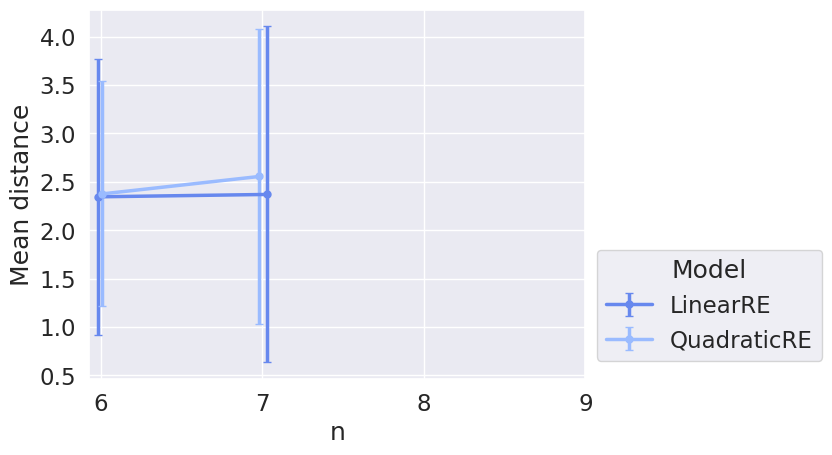

In [61]:
plot_multiple_error_bars(data=data_collapsed.loc[(data_collapsed['model_name']=='QuadraticGlobalRE') | (data_collapsed['model_name']=='LinearGlobalRE')], 
                         var_y='mean_distance_init_coms_go', 
                         ylabel='Mean distance',
                         alt_labels={'QuadraticGlobalRE':'QuadraticRE', 'LinearGlobalRE':'LinearRE'},
                         file_name=None if on_colab else 'distance-go-coms-n',
                         output_dir=figures_output_dir)

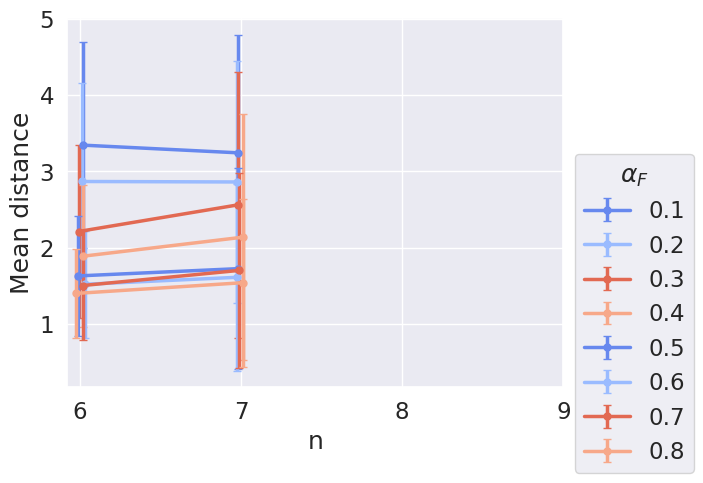

In [60]:
plot_multiple_error_bars(data=data_collapsed, 
                         var_y='mean_distance_init_coms_go', 
                         ylabel='Mean distance',
                         var_hue='weight_faithfulness', 
                         hue_title=r'$\alpha_F$', 
                         file_name=None if on_colab else 'distance-go-coms-al',
                         output_dir=figures_output_dir)

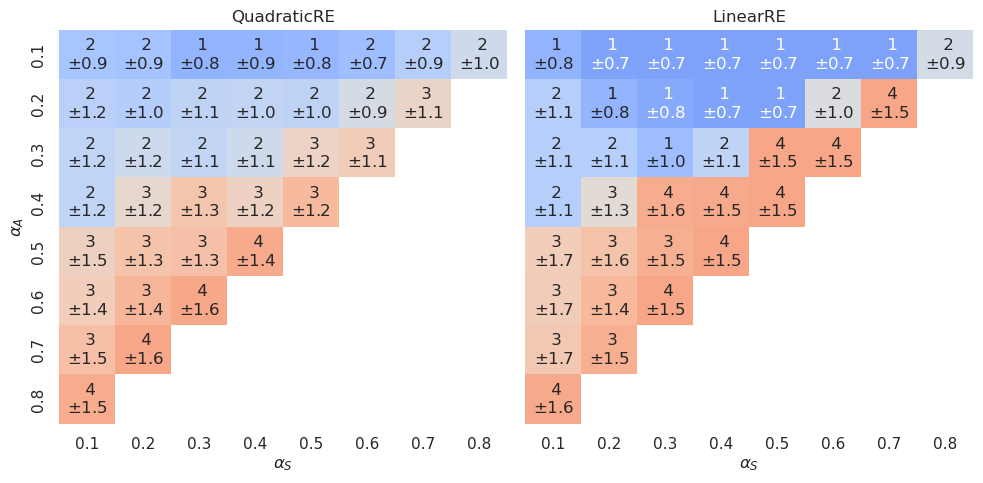

In [62]:
heat_maps_by_weights(re_data = data_collapsed.loc[(data_collapsed['model_name']=='QuadraticGlobalRE') | (data_collapsed['model_name']=='LinearGlobalRE')], 
                     values = 'mean_distance_init_coms_go', 
                     #title = 'Distance initial and go commitments', 
                     col_model='q_or_l_model',
                     annot_std = True, annot_std_fmt = r'$\pm${:2.1f}', 
                     vmin=0, vmax=5,
                     file_name=None if on_colab else 'hm-mean-distance-init-coms-go', 
                     output_dir=figures_output_dir)

## Branches

### Counting fixed points

In [63]:
cols_group_branches = ['model_name','ds','init_coms', 'weight_account', 'weight_systematicity'] 
data_collapsed = re_data.drop_duplicates(cols_group_branches)

In [64]:
data_collapsed.groupby('model_name')['n_fixed_points'].describe()

,count,mean,std,min,25%,50%,75%,max
model_name,,,,,,,,
LinearGlobalRE,1440.0,1.656944,1.839368,1.0,1.0,1.0,2.0,36.0
LinearLocalRE,1440.0,1.210417,0.558741,1.0,1.0,1.0,1.0,6.0
QuadraticGlobalRE,1440.0,1.795833,1.716529,1.0,1.0,1.0,2.0,36.0
QuadraticLocalRE,1440.0,1.859028,1.351493,1.0,1.0,1.0,2.0,11.0


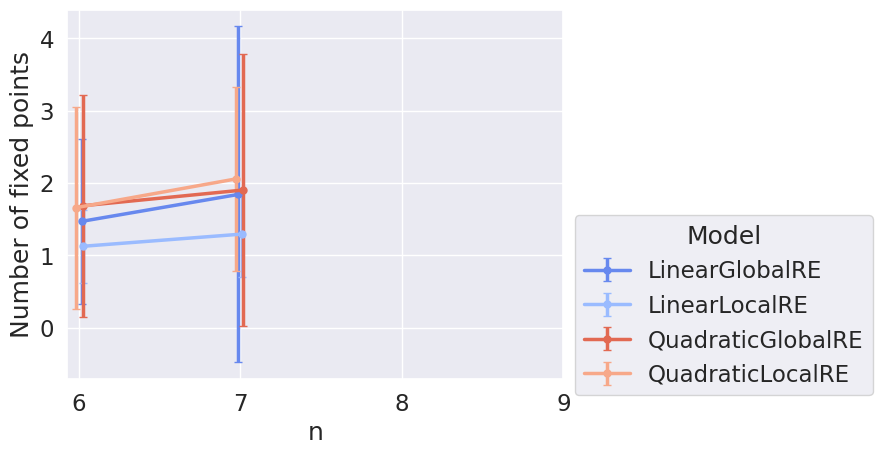

In [65]:
# n_fixed_points (by model)
plot_multiple_error_bars(data=data_collapsed, 
                         var_y='n_fixed_points', 
                         ylabel='Number of fixed points',
                         file_name=None if on_colab else 'number_fixed_points', 
                         output_dir=figures_output_dir)


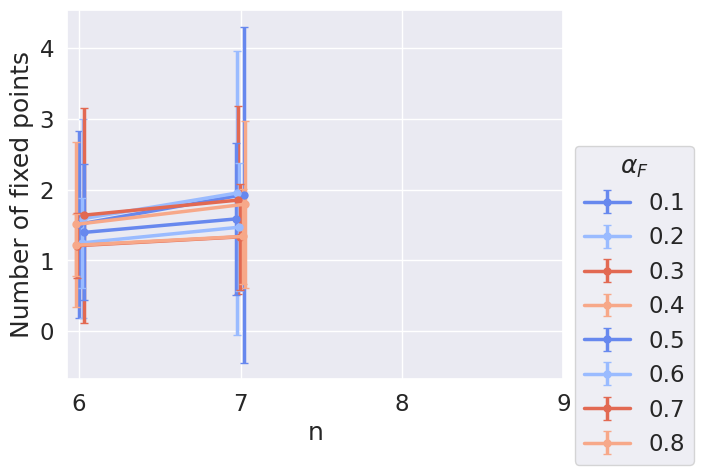

In [66]:
# n_fixed_points (by alpha_f)
plot_multiple_error_bars(data=data_collapsed, 
                         var_y='n_fixed_points', 
                         ylabel='Number of fixed points',
                         var_hue='weight_faithfulness', 
                         hue_title=r'$\alpha_F$', 
                         file_name=None if on_colab else 'number_global_optima', 
                         output_dir=figures_output_dir)


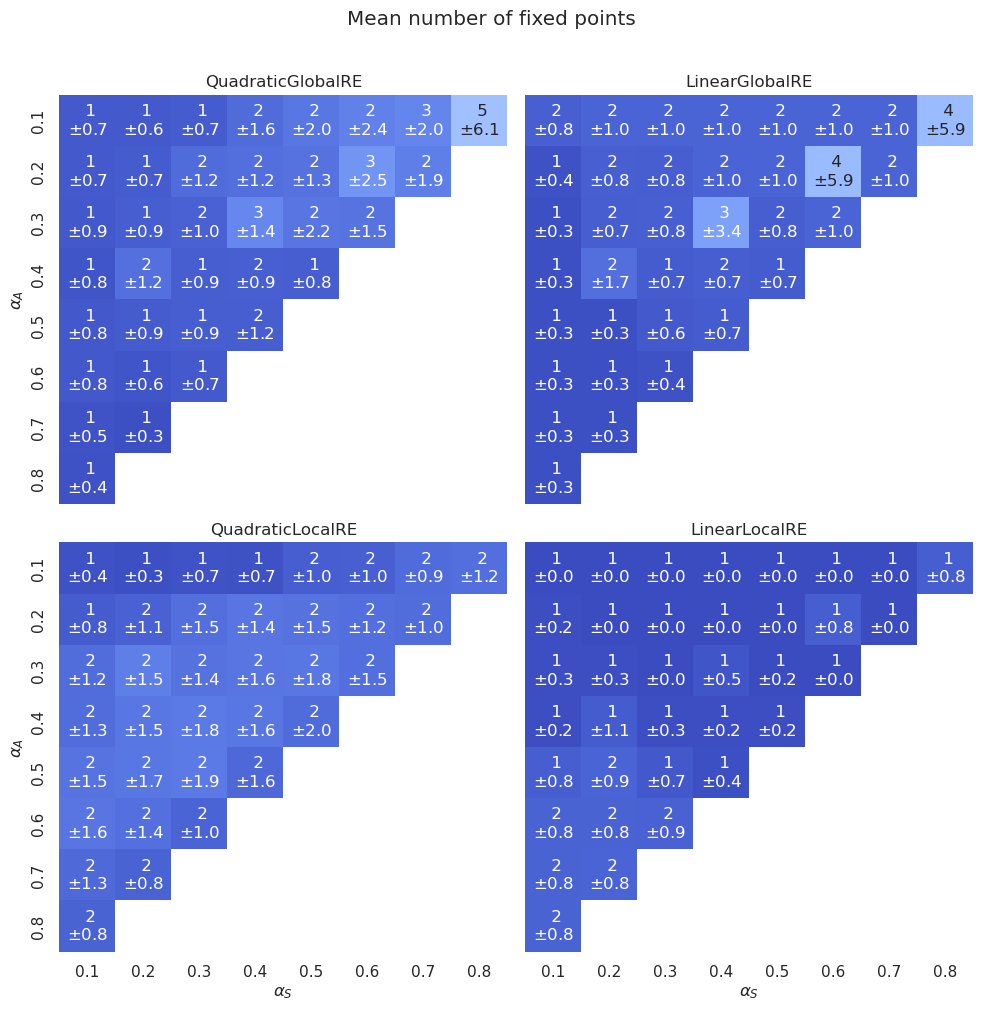

In [67]:
heat_maps_by_weights(re_data = data_collapsed, 
                     values = 'n_fixed_points', 
                     title = 'Mean number of fixed points', 
                     annot_std = True, annot_std_fmt = r'$\pm${:2.1f}', vmin=1, vmax=13,
                     file_name=None if on_colab else 'hm-mean-n-fixed-points', 
                     output_dir=figures_output_dir)

### Counting branches

In [68]:
# Cols that should have identical values for all branches (and only for those) that belong to one branching model run
cols_group_branches = ['model_name', 'ds','init_coms', 'weight_account', 'weight_systematicity', 'weight_faithfulness', 'n_sentence_pool'] 
#cols_group_branches = ['model_name', 'model_short_name', 'ds','init_coms', 'weight_account', 'weight_systematicity', 'weight_faithfulness'] 

# Calculating the number of branches for each model run
df_branches = DataFrame({'n_branches' : re_data.groupby(cols_group_branches).size()}).reset_index()

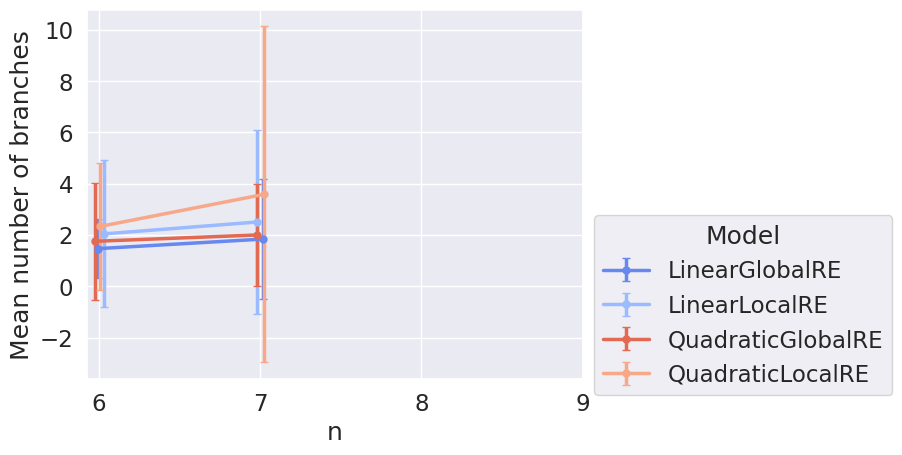

In [69]:
plot_multiple_error_bars(data=df_branches, 
                         var_y='n_branches', 
                         ylabel='Mean number of branches',
                         file_name=None if on_colab else 'mean-branches', 
                         output_dir=figures_output_dir)

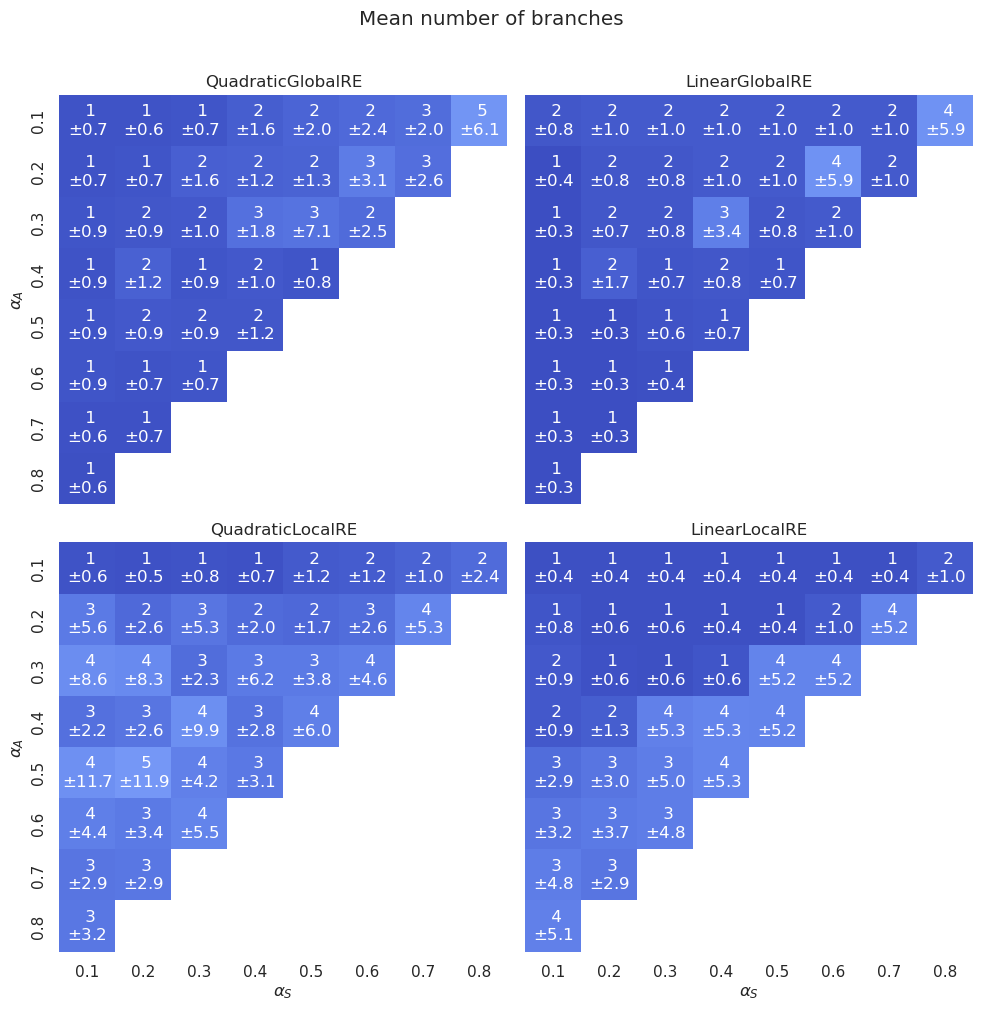

In [70]:
heat_maps_by_weights(re_data = df_branches, values = 'n_branches', 
                     title = 'Mean number of branches', 
                     annot_std = True, annot_std_fmt = r'$\pm${:2.1f}', vmin=1, vmax=22,
                     file_name=None if on_colab else 'hm-mean-branches', 
                     output_dir=figures_output_dir,
                     col_order=['QuadraticGlobalRE', 'LinearGlobalRE', 
                                'QuadraticLocalRE', 'LinearLocalRE' ])